In [1]:
## config, edit
# https://docs.esmvaltool.org/projects/ESMValCore/en/latest/api/esmvalcore.config.html
from esmvalcore.config import CFG
from esmvalcore.dataset import Dataset
CFG.load_from_file('/home/189/fc6164/esmValTool/config-fc-copy.yml')

### double_ITCZ_sea_cycle: meridional structure of the amplitude of the mean seasonal cycle of PR in the eastern Pacific

Computes the meridional root mean square error (RMSE) of eastern Pacific (15°S-15°N) amplitude (standard deviation) of the mean annual cycle (zonal 150-90°W average) precipitation (PR) between model and observations (the time averaging creates a 12 months mean annual cycle time series from which the standard deviation is computed)

## Dataset

In [2]:
#GPCPv2.3 1979-2018 (main) # 20CRv2 1871-2012, CMAP 1979-2018, ERA-Interim 1979-2018, NCEP2 1979-2018

obs = Dataset(dataset= 'GPCP-SG', project= 'OBS', type= '*', version='*', 
                    timerange='1979/2018', tier='2', mip='Amon', short_name='pr')
# list(obs.from_files())
obs.files

[LocalFile('/g/data/kj13/datasets/esmvaltool/obsdata-v2/Tier2/GPCP-SG/OBS_GPCP-SG_atmos_2.3_Amon_pr_197901-202304.nc')]

In [2]:

## model
var = Dataset(
    short_name='pr',
    mip='Amon',
    project='CMIP6',
    activity='CMIP',
    dataset='ACCESS-CM2',
    ensemble='r1i1p1f1',
    institute='*',
    grid='*',
    exp='historical',
    timerange='1979/2014',
    # derive='true'
)
list(var.from_files())[0].files
var.files


[LocalFile('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/pr/gn/v20191108/pr_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc')]

Regridding:
model and observations regridded toward a generic 1°x1° grid (using cdms esmf linear method)

Steps (computation):
- detrending (if applicable)
- mean annual cycle computation
- standard deviation computation
- regridding (if applicable)
- zonal average
- RMSE computation

In [4]:
import iris
from esmvalcore.preprocessor import (
                detrend, # dimension, method, 
                meridional_statistics, # 
                zonal_statistics,
                regrid, #esmf bilinear
                mask_landsea,
                convert_units,
                extract_region, # equatorial pacific #1 - 150°E-90°W, zonal 5°S-5°N average
                climate_statistics ) # month mean, standard deviation

import numpy as np

In [5]:

## base
def preproc_base(cube):
    cube = convert_units(cube,'mm day-1')
    
    cube = extract_region(cube, 210, 270, -15,15) #150, 270, -15,15
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = climate_statistics(cube,'mean', period='monthly')

    return cube


# level 1 plot - obs and model? with collapsed
def preproc_3_1(cube):
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = zonal_statistics(cube, 'mean') #
    
    return cube


# rmse calc from obs
def rmse(obs_cube, model_cube):
    return np.sqrt(np.mean((obs_cube.data - model_cube.data) ** 2))

In [6]:
datasets = [obs,var]
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

#plot 1
process = {}
for ds in datasets:
    cube_process = preproc_base(ds.load())
    cube_process.coord('month_number').guess_bounds()
    cube_process = cube_process.collapsed('month_number', iris.analysis.STD_DEV)
    
    process[ds['dataset']] = preproc_3_1(cube_process)
    print(cube_process.data.max(),cube_process.data.min(),cube_process.units)

error = rmse(process['GPCP-SG'], process['ACCESS-CM2'])  #'numpy.float32' object is not callable
print(error)

5.424761 0.031770337 mm day-1
8.090615 0.05952447 mm day-1
1.5321599186402401


Text(0.5, 0, 'latitude')

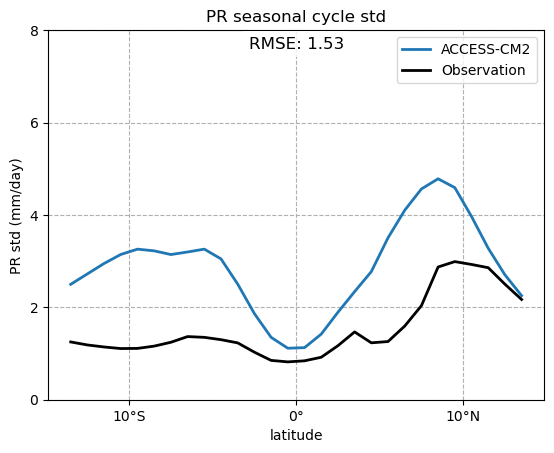

In [11]:
#plot 1
def format_latitude(x):
    if x < 0:
        return f'{abs(x)}°S'
    elif x > 0:
        return f'{x}°N'
    else:
        return '0°'
        
qplt.plot(process['ACCESS-CM2'], label='ACCESS-CM2', linewidth=2)
qplt.plot(process['GPCP-SG'], color='black', label='Observation', linewidth=2)

plt.text(0.5, 0.95, f'RMSE: {error:.2f}', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.legend()
# ax = plt.gca()
plt.grid(linestyle='--')
plt.title('PR seasonal cycle std')

plt.yticks(np.arange(0,9, step=2))
plt.ylabel('PR std (mm/day)')

xt = np.arange(-10,15,step=10)
xlab = [format_latitude(x) for x in xt]
plt.xticks(xt,xlab)
plt.xlabel('latitude')


In [12]:
#diagnostic level 2

process={}
for ds in datasets:
    cube_process = preproc_base(ds.load())# collect from 1? -different extent
    cube_process.coord('month_number').guess_bounds()
    process[ds['dataset']] = cube_process.collapsed('month_number', iris.analysis.STD_DEV)

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'projection'
  result = super().contourf(*args, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'projection'
  result = super().contourf(*args, **kwargs)


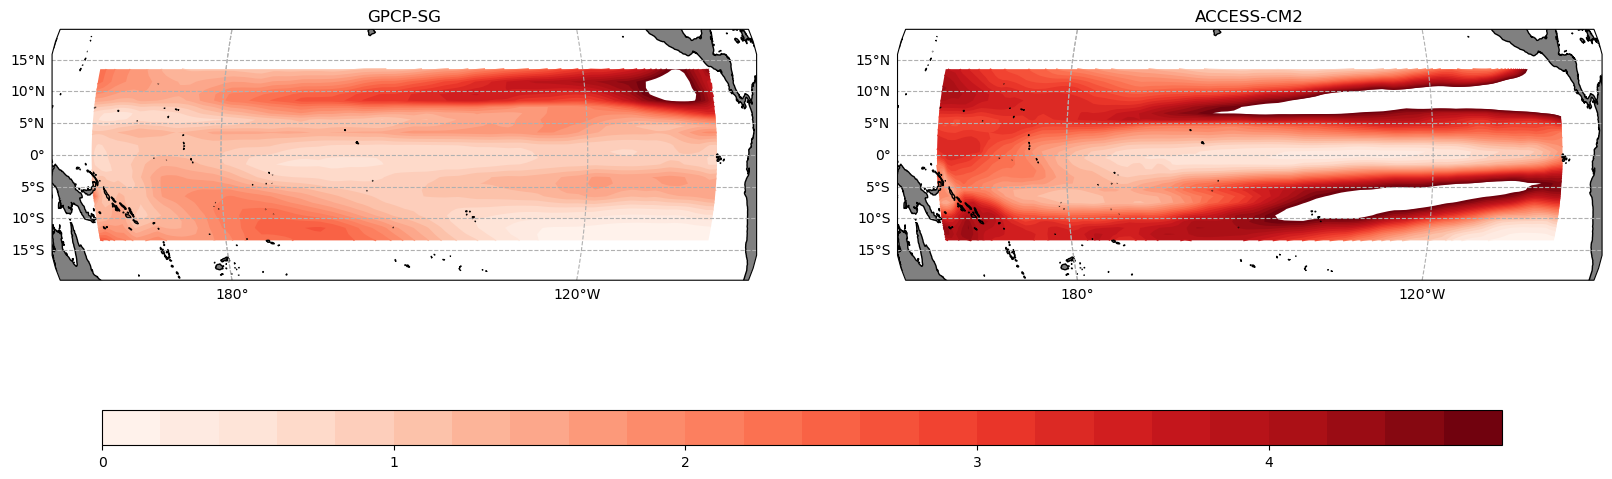

In [14]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.Orthographic(central_longitude=210.0)
i =121

# axls = []
for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(0,5,0.2),projection=proj, cmap='Reds')

    ax1.set_extent([130, 290, -20, 20], crs=ccrs.PlateCarree())
    ax1.set_title(label)

    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(0,6,1))
cbar.set_label('PR std ')

In [42]:
#diagnostic level3
process = {}
for ds in datasets:
    cube_process = preproc_base(ds.load())
    process[ds['dataset']] = preproc_3_1(cube_process)

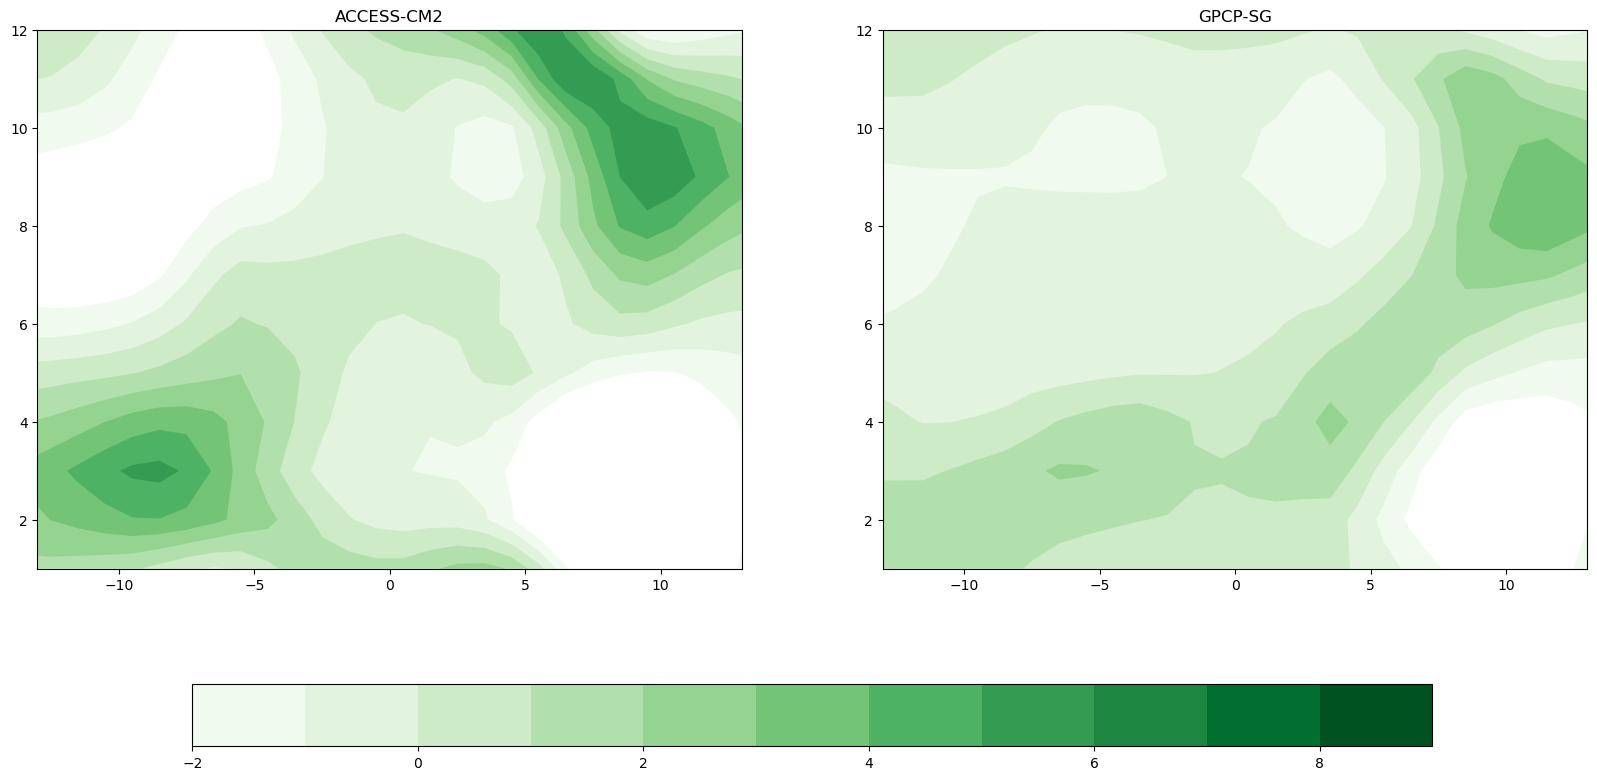

In [63]:
fig = plt.figure(figsize=(20, 10))
i=121
axls =[]
for label, cube in process.items():
    
    ax1 = plt.subplot(i)
    cf1 = iplt.contourf(cube,coords=['latitude','month_number'],levels=np.arange(-2,10,1),cmap='Greens')#, levels=np.arange(0,15,1),cmap='Greens' )
    ax1.set_ylim(1, 12) #label months
    ax1.set_xlim(-13, 13) #lat
    ax1.set_title(label)
    axls.append(ax1)
    i+=1

# Add a single colorbar at the bottom
# cax = plt.add_axes([0.15,0.08,0.7,0.03])
cbar = fig.colorbar(cf1, ax=axls, orientation='horizontal',shrink=0.8, extend='both')